<a href="https://colab.research.google.com/github/teticio/aventuras-con-textos/blob/master/Atencion_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention = Atención

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)

# Attention = Attention

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)

### Importar las librerías

### Import libraries

In [0]:
import re
import os
import random
import numpy as np
import seaborn as sn
import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, get_file
from keras.engine import Layer
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras.layers import Embedding, Concatenate, Dropout
from keras.models import Model
from keras import initializers
import keras.backend as K

checkpoint_dir = 'checkpoints'

### Conectar con Google Drive

### Connect with Google Drive

In [0]:
try:  # estamos en Google Colab?
      # are we in Google Colab?
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints'
except:
    pass

try:  # crear directorio para los checkpoints (si no exista ya)
      # create directtory for the checkpoints (if it doesn't already exist)
    os.makedirs(checkpoint_dir)
except FileExistsError:
    pass

### Podemos usar un conjunto de datos con un vocabulario muy limitado para facilitar el entrenamiento...

### We can use a set of data with a very limited vocabulary to facilitate training...

In [0]:
path_en = get_file(
    'small_vocab_en',
    origin=
    'https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_en'
)
path_fr = get_file(
    'small_vocab_fr',
    origin=
    'https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_fr'
)

with open(path_en, 'rt', encoding='utf-8') as file:
    native = [line.strip() for line in file.readlines()]
with open(path_fr, 'rt', encoding='utf-8') as file:
    foreign = [line.strip() for line in file.readlines()]

### ...o un conjunto de datos más interesante

### ...or a more interesting data set

In [0]:
# puedes encontrar otros texto paralelos aquí
# cuidado porque se actualizan periodicamente
# https://www.manythings.org/anki/

# you can find other parallel texts here
# be careful because they are updated periodically
# https://www.manythings.org/anki/

path_to_zip = get_file(
    'spa-eng.zip',
    origin=
    'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

native = []
foreign = []
with open(path_to_file, 'rt', encoding='utf-8') as file:
    for line in file.readlines():
        tab = line.find('\t')
        native += [line[:tab]]
        foreign += [line[tab + 1:-1]]

In [0]:
native[123], foreign[123]

('Help me!', 'Ayúdame.')

### Añadir los tokens que marcan el comienzo ("[SOS]") y el final ("[EOS]") de cada frase

¡Tal vez "[SOS]" no es una buena elección porque "sos" quiere decir "eres" en argentina...!

### Add the tokens that mark the beginning ("[SOS]") and the end ("[EOS]") of each sentence

Maybe "[SOS]" is not a good choice because "sos" means "you are" in Argentina ...!

In [0]:
foreign = ['[SOS] ' + _ + ' [EOS]' for _ in foreign]

In [0]:
native[123], foreign[123]

('Help me!', '[SOS] Ayúdame. [EOS]')

### Tokenizar

### Tokenize

In [0]:
max_words = 100000  #@param {type : 'number'}

native_tokenizer = Tokenizer(num_words=max_words, oov_token='[UNK]')
native_tokenizer.fit_on_texts(native)
native_index2word = dict(
    zip(native_tokenizer.word_index.values(),
        native_tokenizer.word_index.keys()))
native = native_tokenizer.texts_to_sequences(native)
native_vocab_size = min(max_words,
                        len(native_tokenizer.index_word.keys()) + 1)  # pad = 0

foreign_tokenizer = Tokenizer(num_words=max_words, oov_token='[UNK]')
foreign_tokenizer.fit_on_texts(foreign)
foreign_index2word = dict(
    zip(foreign_tokenizer.word_index.values(),
        foreign_tokenizer.word_index.keys()))
foreign = foreign_tokenizer.texts_to_sequences(foreign)
foreign_vocab_size = min(max_words,
                         len(foreign_tokenizer.index_word.keys()) +
                         1)  # pad = 0

In [0]:
native_vocab_size, foreign_vocab_size

(13526, 26937)

In [0]:
native[123], foreign[123]

([87, 18], [2, 2340, 3])

In [0]:
[native_index2word.get(_, "")
 for _ in native[123]], [foreign_index2word.get(_, "") for _ in foreign[123]]

(['help', 'me'], ['sos', 'ayúdame', 'eos'])

### Hacer que las secuencias tienen el mismo tamaño

### Make the sequences have the same size

In [0]:
max_len = 20  #@param {type : 'number'}

native = sequence.pad_sequences(native,
                                maxlen=max_len,
                                padding='pre',
                                truncating='post')
foreign = sequence.pad_sequences(foreign,
                                 maxlen=max_len,
                                 padding='post',
                                 truncating='post')  # OJO

In [0]:
native[123], foreign[123]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 87, 18], dtype=int32),
 array([   2, 2340,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

### Seq2Seq para NMT (*Neural Machine Translation*)
![texto alternativo](https://miro.medium.com/max/1000/1*7Ki7jDc2f_fH1mHluoZKpA.jpeg)
https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

### Seq2Seq for NMT (*Neural Machine Translation*)
![](https://miro.medium.com/max/1000/1*7Ki7jDc2f_fH1mHluoZKpA.jpeg)
https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

### Capa de Keras para convertir los tokens a vectores one hot

### Keras layer to convert tokens to one hot vectors

In [0]:
class OneHot(Layer):
    def __init__(self, number_of_tokens, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.number_of_tokens = number_of_tokens

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        return K.one_hot(inputs, self.number_of_tokens)

    def compute_output_shape(self, input_shape):
        return input_shape + (self.number_of_tokens, )

### Generador para pasar los token objetivos a vectores one hot

### Generator to pass target tokens to one hot vectors

In [0]:
def batch_generator(x, y, num_tokens, batch_size=128):
    indices = np.random.permutation(len(y))
    i = 0
    while True:
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = [x[0][batch], x[1][batch]]
        batch_Y = to_categorical(y[batch], num_tokens)
        i = i + 1
        if end >= len(y):
            i = 0
        yield (batch_X, batch_Y)

### Crear el modelo: el *encoder*

### Create the model: the *encoder*

In [0]:
num_hidden_units = 1024  #@param {type : 'number'}
embedding_dim = 256  #@param {type : 'number'}

encoder_inputs = Input(shape=(max_len, ), name='encoder_inputs')

#encoder_embedding = OneHot(native_vocab_size)
encoder_embedding = Embedding(native_vocab_size,
                              embedding_dim,
                              name='encoder_embedding')
encoder_in = encoder_embedding(encoder_inputs)

encoder_lstm = LSTM(num_hidden_units,
                    return_state=True,
                    return_sequences=True,
                    name='encoder_lstm')
encoder_out, state_h, state_c = encoder_lstm(
    encoder_in)  # utilizaremos los output en otro modelo más adelante
                 # we will use these outputs in another model later on

encoder_states = [state_h, state_c]

W1020 17:44:13.051251 140045711898432 deprecation_wrapper.py:119] From /home/teticio/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1020 17:44:13.064556 140045711898432 deprecation_wrapper.py:119] From /home/teticio/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1020 17:44:13.072016 140045711898432 deprecation_wrapper.py:119] From /home/teticio/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



### el *decoder*

### the *decoder*

In [0]:
decoder_inputs = Input(
    shape=(max_len - 1, ),
    name='decoder_inputs')  # OJO: secuencia con [SOS] pero sin [EOS]
                            # careful: the sequence contains [SOS] but not [EOS]

#decoder_embedding = OneHot(foreign_vocab_size)
decoder_embedding = Embedding(foreign_vocab_size,
                              embedding_dim,
                              name='decoder_embedding')
decoder_in = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(num_hidden_units,
                    return_sequences=True,
                    return_state=True,
                    name='decoder_lstm')
decoder_out, _, _ = decoder_lstm(decoder_in, initial_state=encoder_states)

decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense, name='decoder_dense')(
    decoder_out
)  # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

### y el modelo completo

### and the complete model

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

print('FULL MODEL')
model.summary()

W1020 17:44:16.686237 140045711898432 deprecation_wrapper.py:119] From /home/teticio/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1020 17:44:16.697616 140045711898432 deprecation_wrapper.py:119] From /home/teticio/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 19, 256)      6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

### Entrenar el modelo

### Train the model

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')
batch_size = 512  #@param {type : 'number'}
model.fit_generator(batch_generator([native, foreign[:, :-1]],
                                    foreign[:, 1:],
                                    foreign_vocab_size,
                                    batch_size=batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=25)

W0814 13:58:20.874777 139887211951936 deprecation.py:323] From /usr/lib/python3/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0814 13:58:21.605696 139887211951936 deprecation_wrapper.py:119] From /usr/lib/python3/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/25
233/233 [==============================] - 194s 832ms/step - loss: 2.2948 - acc: 0.6794
Epoch 2/25
233/233 [==============================] - 191s 822ms/step - loss: 1.7211 - acc: 0.7292
Epoch 3/25
233/233 [==============================] - 191s 821ms/step - loss: 1.4353 - acc: 0.7598
Epoch 4/25
233/233 [==============================] - 191s 820ms/step - loss: 1.2076 - acc: 0.7886
Epoch 5/25
233/233 [==============================] - 191s 820ms/step - loss: 1.0273 - acc: 0.8123
Epoch 6/25
233/233 [==============================] - 191s 821ms/step - loss: 0.8794 - acc: 0.8334
Epoch 7/25
233/233 [==============================] - 191s 821ms/step - loss: 0.7569 - acc: 0.8518
Epoch 8/25
233/233 [==============================] - 191s 820ms/step - loss: 0.6538 - acc: 0.8685
Epoch 9/25
233/233 [==============================] - 191s 821ms/step - loss: 0.5645 - acc: 0.8835
Epoch 10/25
233/233 [==============================] - 191s 821ms/step - loss: 0.4859 - acc: 0.8977
Epoch 11/

In [0]:
model.save_weights(checkpoint_dir + '/Seq2SeqModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')

### Visualizar los embedding

### Display embedding

In [0]:
def plot_tsne(embedding_matrix, index_to_word, num_words=None, title='t-SNE'):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words, :]
    labels = [index_to_word.get(_, "<UNK>") for _ in range(matrix.shape[0])]

    # defining the chart
    output_notebook()
    fig = bp.figure(plot_width=700,
                    plot_height=600,
                    title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None,
                    y_axis_type=None,
                    min_border=1)

    # dimensionality reduction. converting the vectors to 2d vectors
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = labels

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {"": "@words"}
    show(fig)

In [0]:
plot_tsne(encoder_embedding.get_weights()[0],
          native_index2word,
          title='English')

Loading BokehJS ...

In [0]:
plot_tsne(decoder_embedding.get_weights()[0],
          foreign_index2word,
          title='Spanish')

Loading BokehJS ...

### *Teacher Forcing*



``model_inputs = [native, foreign[:,:-1]], model_outputs = foreign[:, 1:]
``

### Teacher Forcing



`` model_inputs = [native, foreign[:,:-1]], model outputs = foreign[:, 1:]
``

In [0]:
for i in range(10):
    ind = random.randint(0, len(native))
    sentence = (' ').join([native_index2word.get(_, '') for _ in native[ind]])
    target_sentence = (' ').join(
        [foreign_index2word.get(_, '') for _ in foreign[ind][1:]])
    seq = np.expand_dims(native[ind], axis=0)

    # empieza bien, pero rápidamente pierde el hilo
    # it starts off well, but it quickly loses the thread
    dec_inputs = np.zeros((1, max_len - 1))
    dec_inputs[0, 0] = foreign_tokenizer.word_index['sos']
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence = ' '.join(
        [foreign_index2word.get(_, '') for _ in tokens])

    # esto va mejor, pero es hacer "trampa"...
    # this works better, but it is "cheating"...
    dec_inputs = np.expand_dims(foreign[ind, :-1], axis=0)
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence_with_teacher_forcing = ' '.join(
        [foreign_index2word.get(_, '') for _ in tokens])

    print(sentence)
    print(translated_sentence)
    print(translated_sentence_with_teacher_forcing)
    print(target_sentence)
    print()

           i'll have two hot dogs with mustard and ketchup
llevaré de                 
llevaré dos completos dogs con mostaza y ketchup eos          
llevaré dos hot dogs con mostaza y ketchup eos          

 if you say exactly what's on your mind all the time you're likely to upset a lot of people
si a                 
si te hace a decir sobre te que te te pasa por la cabeza es probable que molestes a
si te dedicas a decir siempre lo que se te pasa por la cabeza es probable que molestes a

           she hit me on the head with a hammer
ella de                 
ella me pegó en la cabeza con un martillo eos         
ella me pegó en la cabeza con un martillo eos         

               the church bells are ringing
las la                 
las campanas de la iglesia están sonando eos           
las campanas de la iglesia están sonando eos           

            you must talk with him about the matter
debes a                 
debes hablar con él sobre el asunto eos           
debes habla

### Definir un encoder para hacer inferencia
![](https://miro.medium.com/max/700/1*xDPdW9nf7HdVDcBCQUJG7A.jpeg)

### Define an encoder for inference
![](https://miro.medium.com/max/700/1*xDPdW9nf7HdVDcBCQUJG7A.jpeg)

In [0]:
encoder_inf_inputs = Input((max_len, ), name='encoder_inf_inputs')

encoder_inf_in = encoder_embedding(encoder_inf_inputs)

encoder_inf_out, state_h, state_c = encoder_lstm(encoder_inf_in)

encoder_model = Model(inputs=encoder_inf_inputs,
                      outputs=[encoder_inf_out, state_h, state_c])

print('ENCODER')
encoder_model.summary()

ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay (None, 20)                0         
_________________________________________________________________
encoder_embedding (Embedding (None, 20, 256)           3462656   
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 20, 1024), (None, 5246976   
Total params: 8,709,632
Trainable params: 8,709,632
Non-trainable params: 0
_________________________________________________________________


### y un decoder para hacer inferencia

### and a decoder for inference

In [0]:
decoder_init_states = [
    Input((num_hidden_units, ), name='encoder_state_h'),
    Input((num_hidden_units, ), name='encoder_state_c')
]
encoder_inf_outputs = Input((max_len, num_hidden_units),
                            name='encoder_inf_outputs')
decoder_inf_inputs = Input((1, ), name='decoder_inf_inputs')  # token por token

decoder_inf_in = decoder_embedding(decoder_inf_inputs)

decoder_inf_out, state_h, state_c = decoder_lstm(
    decoder_inf_in, initial_state=decoder_init_states)

decoder_inf_pred = TimeDistributed(decoder_dense,
                                   name='decoder_inf_dense')(decoder_inf_out)

decoder_model = Model(inputs=[encoder_inf_outputs] + decoder_init_states +
                      [decoder_inf_inputs],
                      outputs=[decoder_inf_pred, state_h, state_c])

print('DECODER')
decoder_model.summary()

DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inf_inputs (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inf_inputs[0][0]         
__________________________________________________________________________________________________
encoder_state_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
encoder_state_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
de

### *Greedy decoding*

### Greedy decoding

In [0]:
# phrase in english
frase_en_ingles = "Who did you go to the movie theater with?"  #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq,
                             maxlen=max_len,
                             padding='pre',
                             truncating='post')
sentence = (' ').join([native_index2word.get(_, '') for _ in seq[0]])
print(sentence)

           who did you go to the movie theater with


In [0]:
enc_outputs, h, c = encoder_model.predict(seq)
dec_inputs = np.expand_dims(foreign_tokenizer.word_index['sos'], axis=0)
translated_sentence = ''
for i in range(max_len):
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    token = np.argmax(dec_outputs, axis=-1)[0, 0]
    word = foreign_index2word.get(token, '')
    if word == '' or word == 'eos':
        break
    dec_inputs = np.expand_dims(token, axis=0)
    translated_sentence += word + ' '
print(translated_sentence)

¿con quién fuiste el cine 


### *Beam Search* (beam = haz luminoso)

En lugar de simplemente elegir la palabra más probable en cada paso según $P[x_i]$, queremos elegir la frase más probable. Para ello, usamos la red para calcular las probabilidades de cada palabra condicionada en la previa $P[x_i|x_{i-1}]$. Queremos la frase $x_0 x_1 ... x_n$ con mayor probabilidad $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$.

El número de probabilidades que tenemos que calcular en cada paso expande como una "haz luminoso": de allí el nombre del algoritmo [beam search](https://hackernoon.com/beam-search-a-search-strategy-5d92fb7817f). Limitamos la anchura de la haz en cada paso a las $k$ candidatos más probables.

En lugar de $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$ consideramos $\log P[x_0] + \log P[x_1|x_0] + ...  + \log P[x_n|x_{n-1}]$ para poder discriminar entre probabilidades muy pequeñas.

### Beam Search (as in beam of light)

Instead of simply choosing the most likely word in each step according to $P[x_i]$, we want to choose the most likely phrase. To do this, we use the network to calculate the probabilities of each conditioned word in the previous $P[x_i|x_{i-1}]$. We want the phrase $x_0 x_1 ... x_n$ most likely $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$.

The number of probabilities that we have to calculate in each step expands as a "light beam": hence the name of the algorithm [beam search](https://hackernoon.com/beam-search-a-search-strategy-5d92fb7817f). We limit the width of the beam at each step to the most likely $k$ candidates.

Instead of $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$ we consider $\log P[x_0] + \log P[x_1|x_0] + ...  + \log P[x_n|x_{n-1}]$ to be able to discriminate between very small probabilities.

In [0]:
k = 5
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
candidates  # (frase hasta ahora, probabilidad de la última palabra condicionada en la previa, token de la última palabra)
            # (phrase up to this point, probability of the last word conditioned on the previous one, last word token)

[('', 0, 2)]

In [0]:
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])

In [0]:
top_k = [
    np.flip(dec_outputs[token, 0].argsort()[-k:])
    for token in range(min(k, len(candidates)))
]
top_k  # los siguientes token más probables
       # the next most likely

[array([1117,  228,  154,  203,  146])]

In [0]:
next_candidates = [
    (
        candidates[token][0] + ' ' + foreign_index2word.get(
            top_k[token][next_token], ''),  # frase hasta ahora
                                            # phrase up this point
        candidates[token][1] - np.log(
            dec_outputs[token, 0, top_k[token][next_token]]
        ),  # probabilidad de la última palabra condicionada en la previa
            # probability of the last word conditioned on the previous one
        top_k[token][next_token])  # token de la última palabra
                                   # last word token
    for next_token in range(k) for token in range(len(top_k))
]
candidates = sorted(next_candidates, key=lambda x: x[1])[:k]
candidates

[(' ¿con', 0.4866240918636322, 1117),
 (' ¿a', 1.5812753438949585, 228),
 (' ¿quién', 2.240185022354126, 154),
 (' ¿cuándo', 3.1399147510528564, 203),
 (' ¿cómo', 4.075429439544678, 146)]

In [0]:
# preparar batch para predicir las siguientes palabras condicionadas en estas
# prepare a batch to predict the next words conditioned on these ones
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (1, 20, 1024), (1, 1024), (1, 1024))

In [0]:
# igualar los tamaños de los inputs al modelo
# make all the inputs have the same sizes
h = np.repeat(h, dec_inputs.shape[0] - h.shape[0] + 1, axis=0)
c = np.repeat(c, dec_inputs.shape[0] - c.shape[0] + 1, axis=0)
enc_outputs = np.repeat(enc_outputs,
                        dec_inputs.shape[0] - enc_outputs.shape[0] + 1,
                        axis=0)
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (5, 20, 1024), (5, 1024), (5, 1024))

In [0]:
# repetir para la siguiente palabra
# repeat for the next word
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
top_k = [
    np.flip(dec_outputs[token, 0].argsort()[-k:])
    for token in range(min(k, len(candidates)))
]
next_candidates = [
    (
        candidates[token][0] + ' ' + foreign_index2word.get(
            top_k[token][next_token], ''),  # frase hasta ahora
                                            # phrase up this point
        candidates[token][1] - np.log(
            dec_outputs[token, 0, top_k[token][next_token]]
        ),  # probabilidad de la última palabra condicionada en la previa
            # probability of the last word conditioned on the previous one
        top_k[token][next_token])  # token de la última palabra
                                   # last word token
    for next_token in range(k) for token in range(len(top_k))
]
sorted(next_candidates, key=lambda x: x[1])

[(' ¿con quién', 0.48712191451340914, 194),
 (' ¿a quién', 1.5822547700954601, 194),
 (' ¿quién te', 2.549068808555603, 31),
 (' ¿cuándo te', 3.300738885998726, 31),
 (' ¿cómo te', 4.219764709472656, 31),
 (' ¿quién quién', 4.591186761856079, 194),
 (' ¿quién fuiste', 4.751844882965088, 1481),
 (' ¿cuándo fuiste', 5.65768575668335, 1481),
 (' ¿cómo fuiste', 6.586045265197754, 1481),
 (' ¿quién ha', 6.618316888809204, 58),
 (' ¿quién pudo', 6.878216028213501, 297),
 (' ¿cuándo va', 7.0301947593688965, 113),
 (' ¿cuándo ustedes', 7.315505743026733, 405),
 (' ¿cómo quién', 8.206040382385254, 194),
 (' ¿cuándo fue', 8.256080389022827, 47),
 (' ¿con dónde', 8.353198379278183, 187),
 (' ¿a qué', 8.646265387535095, 35),
 (' ¿cómo os', 9.237038612365723, 591),
 (' ¿cómo ha', 9.33417797088623, 58),
 (' ¿con qué', 10.316176742315292, 35),
 (' ¿con ustedes', 11.051898330450058, 405),
 (' ¿a dónde', 11.194592833518982, 187),
 (' ¿con cuándo', 12.201133102178574, 638),
 (' ¿a ti', 12.42308938503265

### Juntamos las piezas

### We put the pieces together

In [0]:
k = 40  #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0] - h.shape[0] + 1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0] - c.shape[0] + 1, axis=0)
    enc_outputs = np.repeat(enc_outputs,
                            dec_inputs.shape[0] - enc_outputs.shape[0] + 1,
                            axis=0)
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    top_k = [
        np.flip(dec_outputs[token, 0].argsort()[-k:])
        for token in range(min(k, len(candidates)))
    ]
    next_candidates = [
        (
            candidates[token][0] + ' ' + foreign_index2word.get(
                top_k[token][next_token], ''),  # frase hasta ahora
                                                # phrase up this point
            candidates[token][1] - np.log(
                dec_outputs[token, 0, top_k[token][next_token]]
            ),  # probabilidad de la última palabra condicionada en la previa
                # probability of the last word conditioned on the previous one
            top_k[token][next_token])  # token de la última palabra
                                       # last word token
        for next_token in range(k) for token in range(len(top_k))
    ]
    candidates = sorted(next_candidates, key=lambda x: x[1])[:k]
    print(candidates[0][0])
    #    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
    #        break
    dec_inputs = np.array([[_[2]] for _ in candidates])

 ¿con
 ¿con quién
 ¿con quién fuiste
 ¿con quién fuiste el
 ¿con quién fuiste el cine
 ¿con quién fuiste el cine eos
 ¿con quién fuiste el cine eos 
 ¿con quién fuiste el cine eos  
 ¿con quién fuiste el cine eos   
 ¿con quién fuiste el cine eos    
 ¿con quién fuiste el cine eos     
 ¿con quién fuiste el cine eos      
 ¿con quién fuiste el cine eos       
 ¿con quién fuiste el cine eos        
 ¿con quién fuiste el cine eos         
 ¿con quién fuiste el cine eos          
 ¿con quién fuiste el cine eos           
 ¿con quién fuiste el cine eos            
 ¿con quién fuiste el cine eos             
 ¿con quién fuiste el cine eos              


In [0]:
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

1. ¿con quién fuiste el cine eos              
2. ¿con quién fuiste el cine con el cine eos           
3. ¿a quién fuiste el primero en el cine eos           
4. ¿a quién fuiste el cine eos              
5. ¿quién te gustaría ir al cine eos             
6. ¿con quién fuiste el primero que ver eos            
7. ¿a quién fuiste el primero el cine eos            
8. ¿quién te fuiste al cine eos              
9. ¿con quién fuiste el primero en la cine eos           
10. ¿a quién fuiste el cine al cine eos            
11. ¿cuándo te gustaría ir al cine eos             
12. ¿cómo te fuiste el cine al cine eos            
13. ¿con quién fuiste el primero que dejé de viaje eos          
14. ¿con quién fuiste el primero que dejé de trabajo eos          
15. ¿con quién fuiste el cine con nosotras comercial eos           
16. ¿a quién fuiste el cine el cine eos            
17. ¿a quién fuiste el primero ver al cine eos           
18. ¿con quién fuiste el primero que dejé de eos           
19. ¿c

# *Attention*
![](https://miro.medium.com/max/700/1*TkVKlV-Pk7POJUhlWHRgDA.png)
![](https://miro.medium.com/max/700/1*wcxAAgQ0n9gOXLRqhmaLGA.png)

https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
*  Los LSTM (*Long Short Term Memory*) cuentan con un mecanismo para "recordar" elementos previos de una serie. Para traducir un texto, esto es fundamental porque el contexto influye al significado de una palabra. Sin embargo, a veces no sabemos la importancia de una palabra en una frase hasta más adelante y, en la práctica, tenemos que volver a mirar el texto. Por ejemplo en la frase "*The cat didn't cross the road because it was tired*", sabemos que es la gata que está cansada, no la calle y, por lo tanto, la traducción a español es "*El gato no quería cruzar la calle porque estaba cansado*" y no "*El gato no quería cruzar la calle porque estaba* cansada". El mecanismo de atención puede aprender a asociar "*tired*" con "*cat*" más que con "*street*".
*  [Existen muchas diferentes formas de calcular "*attention*"](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html). Vamos a usar el mismo tipo de atención que se usa en el *transformer* en que está basado BERT.

$$\text{Weights}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\cdot\mathbf{K}^\top}{\sqrt{N}}\right)$$
$$\text{Attention}(\mathbf{Q}, \mathbf{K},\mathbf{V}) = \text{Weights}\cdot\mathbf{V}$$
$$ $$
$$\mathbf{Q}\in\rm I\!R^{n\times N},\mathbf{K},\mathbf{V}\in\rm I\!R^{m\times N}$$
$$\mathbf{Weights}\in\rm I\!R^{n\times m},\mathbf{Attention}\in\rm I\!R^{n\times N}$$

*  Calculamos la atención con *scaled dot product attention*. El dot product es equivalente a la proximidad cosena entre dos vectores.
*  La clave $K$ ("*the key*") es una matriz de $m$ vectores de $N$ estados, la pregunta $Q$ ("*the query*") es una matriz de $n$ vectores de $N$ estados y el valor ("*the value*" $V$) es una matriz de $m$ vectores de $N$ estados. Para nuestro propósito $V=K$.
*  $\mathbf{Q}$, $\mathbf{K}$ y $\mathbf{V}$ son los resultados de multiplicar $Q$, $K$ y $V$ por una matriz de pesos entrenables (una capa dense) del tamaño correspondente.
*  La clave $K$ va a ser la salida del LSTM del encoder y la pregunta $Q$ va a ser la salida del LSTM del decoder.
*  Podemos pasar la salida de atención al LSTM o directamente a la capa dense del decoder. El primer enfoque requiere que pasemos la salida de atención a cada célula del LSTM en serie, mientras el segundo enfoque es más fácil de implementar en Keras ya que podemos simplemente concatenar la matriz la salida de atención con la salida del LSTM. [Aquí](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention) hay una implementación del primer enfoque en TensorFlow.

# *Attention*
![](https://miro.medium.com/max/700/1*TkVKlV-Pk7POJUhlWHRgDA.png)
![](https://miro.medium.com/max/700/1*wcxAAgQ0n9gOXLRqhmaLGA.png)

https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
*   The LSTM (*Long Short Term Memory*) have a mechanism to "remember" previous elements of a series. To translate a text, this is fundamental because the context influences the meaning of a word. However, sometimes we don't know the importance of a word in a sentence until later and, in practice, we have to look back at the text. For example, in the phrase "*The cat didn't cross the road because it was tired*", we know that it is the cat that is tired, not the street and, therefore, the Spanish translation is "*El gato no quería cruzar la calle porque estaba cansado*" and not "*El gato no quería cruzar la calle porque estaba* cansada". The attention mechanism can learn to associate "*tired*" with "*cat*" more than with "*street*". [There are many different ways to calculate "*attention*"](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html). We will use the same type of attention that is used in the *transformer* on which BERT is based.

$$\text{Weights}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\cdot\mathbf{K}^\top}{\sqrt{N}}\right)$$
$$\text{Attention}(\mathbf{Q}, \mathbf{K},\mathbf{V}) = \text{Weights}\cdot\mathbf{V}$$
$$ $$
$$\mathbf{Q}\in\rm I\!R^{n\times N},\mathbf{K},\mathbf{V}\in\rm I\!R^{m\times N}$$
$$\mathbf{Weights}\in\rm I\!R^{n\times m},\mathbf{Attention}\in\rm I\!R^{n\times N}$$

*   We calculate attention with *scaled dot product attention*. The dot product is equivalent to the cosine proximity between two vectors. The key $K$ ("*the key*") is an array of $m$ vectors of $N$ states, the question $Q$ ("*the query*") is an array of $n$ vectors of $N$ states and the value ("*the value*" $V$) is an array of $m$ vectors of $N$ states. For our purposes $V=K$.
*   $\mathbf{Q}$, $\mathbf{K}$ and $\mathbf{V}$ are the results of multiplying $Q$, $K$ and $V$ by a matrix of trainable weights (a dense layer) of the corresponding size. The key $K$ is going to be the LSTM output of the encoder and the query $Q$ is going to be the LSTM output of the decoder.
*   We can pass the attention output to the LSTM or directly to the dense layer of the decoder. The first approach requires that we pass the attention output to each LSTM cell in series, while the second approach is easier to implement in Keras since we can simply concatenate the attention output matrix with the LSTM output. [Here](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention) is an implementation of the first approach in TensorFlow.

### Redefinimos el modelo para incluir una capa de atención

### We redefine the model to include an attention layer

In [0]:
# adaptado de https://github.com/tensorflow/models/blob/master/official/transformer/model/attention_layer.py


class Attention(Layer):
    def __init__(self, hidden_size, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.hidden_size = hidden_size

        # capas dense para los query, key y values
        # Layers for linearly projecting the queries, keys, and values.
        self.q_dense_layer = Dense(hidden_size, use_bias=False, name="q")
        self.k_dense_layer = Dense(hidden_size, use_bias=False, name="k")
        self.v_dense_layer = Dense(hidden_size, use_bias=False, name="v")
        self.output_dense_layer = Dense(hidden_size,
                                        use_bias=False,
                                        name="output_transform")

    def build(self, input_shape):
        # construir las capas
        # build the layers
        self.q_dense_layer.build(input_shape[1])
        self.k_dense_layer.build(input_shape[0])
        self.v_dense_layer.build(input_shape[0])
        self.output_dense_layer.build(input_shape[0])

        # añadir los pesos entrenables
        # add the trainable weights
        self.trainable_weights = self.q_dense_layer.trainable_weights
        self.trainable_weights += self.k_dense_layer.trainable_weights
        self.trainable_weights += self.v_dense_layer.trainable_weights
        self.trainable_weights += self.output_dense_layer.trainable_weights
        super(Attention, self).build(input_shape)

    def call(self, inputs, bias=0):
        """Apply attention mechanism to inputs.
        Args:
          inputs[0]: a tensor with shape [batch_size, length_encoder, hidden_size]
          inputs[1]: a tensor with shape [batch_size, length_decoder, hidden_size]
          bias: attention bias that will be added to the result of the dot product.
        Returns:
          Attention layer output with shape [batch_size, length_decoder, hidden_size]
          Attention weights with shape [batch_size, length_decoder, length_encoder]
        """
        q = self.q_dense_layer(inputs[1])
        k = self.k_dense_layer(inputs[0])
        v = self.v_dense_layer(inputs[0])

        # escalar q para evitar problemas con calcular el producto escalar de q y k
        # Scale q to prevent the dot product between q and k from growing too large.
        depth = self.hidden_size
        q *= depth**-0.5

        # calulcuar atención con el producto escalar
        # Calculate dot product attention
        logits = K.batch_dot(q, K.permute_dimensions(k, [0, 2, 1]))
        logits += bias
        weights = K.softmax(logits)
        attention_output = K.batch_dot(weights, v)

        # pasar los outputs por otra capa dense
        # Run the combined outputs through another linear projection layer.
        attention_output = self.output_dense_layer(attention_output)
        return [attention_output, weights]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0], input_shape[1][1], self.hidden_size),
                (input_shape[1][0], input_shape[1][1], input_shape[0][1])]

### Conectamos las salidas del encoder y el decoder a una capa de atención...

### We connect the encoder and decoder outputs to an attention layer...

In [0]:
attention_hidden_size = 1024  #@param {type : 'number'}

attn_layer = Attention(attention_hidden_size, name='attention')
attn_out, attn_weights = attn_layer([encoder_out, decoder_out])

decoder_cat = Concatenate(name='concatenate')
decoder_merge = decoder_cat([decoder_out, attn_out])

### ...y las salidas de la capa de atención a la capa dense del decoder

### ...and the outputs of the attention layer to the decoder layer

In [0]:
decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense,
                                  name='decoder_dense')(decoder_merge)

### El modelo completo

### The complete model

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

print('FULL MODEL')
model.summary()

FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')
batch_size = 512  #@param {type : 'number'}
model.fit_generator(batch_generator([native, foreign[:, :-1]],
                                    foreign[:, 1:],
                                    foreign_vocab_size,
                                    batch_size=batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=25)

W0815 01:33:58.195178 139960673691456 deprecation.py:323] From /usr/lib/python3/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
233/233 [==============================] - 241s 1s/step - loss: 1.1276 - acc: 0.8330
Epoch 2/25
233/233 [==============================] - 239s 1s/step - loss: 0.5131 - acc: 0.9040
Epoch 3/25
233/233 [==============================] - 240s 1s/step - loss: 0.3438 - acc: 0.9296
Epoch 4/25
233/233 [==============================] - 240s 1s/step - loss: 0.2427 - acc: 0.9466
Epoch 5/25
233/233 [==============================] - 240s 1s/step - loss: 0.1778 - acc: 0.9591
Epoch 6/25
233/233 [==============================] - 240s 1s/step - loss: 0.1354 - acc: 0.9682
Epoch 7/25
233/233 [==============================] - 240s 1s/step - loss: 0.1080 - acc: 0.9745
Epoch 8/25
233/233 [==============================] - 240s 1s/step - loss: 0.0896 - acc: 0.9787
Epoch 9/25
233/233 [==============================] - 240s 1s/step - loss: 0.0769 - acc: 0.9814
Epoch 10/25
233/233 [==============================] - 245s 1s/step - loss: 0.0683 - acc: 0.9832
Epoch 11/25
233/233 [==================

In [0]:
model.save_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

### Añadimos la capa de atención al decoder para hacer inferencia

### We add the attention layer to the decoder for inference

In [0]:
attn_out, attn_weights = attn_layer([encoder_inf_outputs, decoder_inf_out])

decoder_inf_merge = decoder_cat([decoder_inf_out, attn_out])

decoder_inf_pred = TimeDistributed(decoder_dense,
                                   name='decoder_inf_dense')(decoder_inf_merge)

decoder_model = Model(
    inputs=[encoder_inf_outputs] + decoder_init_states + [decoder_inf_inputs],
    outputs=[decoder_inf_pred, state_h, state_c, attn_weights])

print('DECODER')
decoder_model.summary()

DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inf_inputs (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inf_inputs[0][0]         
__________________________________________________________________________________________________
encoder_state_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
encoder_state_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
de

### Beam search con atención

### Beam search with attention

In [0]:
frase_en_ingles = "Who did you go to the movie theater with?"  #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq,
                             maxlen=max_len,
                             padding='pre',
                             truncating='post')
sentence = (' ').join([native_index2word.get(_, '') for _ in seq[0]])
print(sentence)

k = 40  #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'], [])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0] - h.shape[0] + 1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0] - c.shape[0] + 1, axis=0)
    enc_outputs = np.repeat(enc_outputs,
                            dec_inputs.shape[0] - enc_outputs.shape[0] + 1,
                            axis=0)
    dec_outputs, h, c, attn = decoder_model.predict(
        [enc_outputs, h, c, dec_inputs])
    top_k = [
        np.flip(dec_outputs[token, 0].argsort()[-k:])
        for token in range(min(k, len(candidates)))
    ]
    next_candidates = [
        (
            candidates[token][0] + ' ' + foreign_index2word.get(
                top_k[token][next_token], ''),  # frase hasta ahora
                                                # phrase up to this point
            candidates[token][1] - np.log(
                dec_outputs[token, 0, top_k[token][next_token]]
            ),  # probabilidad de la última palabra condicionada en la previa
                # probability of the last word conditioned on the previous one
            top_k[token][next_token],  # token de la última palabra
                                       # last word token
            candidates[token][3] + [attn[token]])  # vectores de atención
                                                   # attention vectors
        for next_token in range(k) for token in range(len(top_k))
    ]
    candidates = sorted(next_candidates, key=lambda x: x[1])[:k]
    #    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
    #        break
    dec_inputs = np.array([[_[2]] for _ in candidates])
attention_matrix = np.concatenate(candidates[0][3], axis=0)
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

           who did you go to the movie theater with
1. ¿con quién fuiste al cine eos              
2. ¿quién fuiste al cine con cine eos             
3. ¿con quién fuiste al cine con frecuencia eos            
4. ¿con quién fuiste al cine con sitio eos            
5. ¿con quién fuiste al cine con john eos            
6. ¿con quién fuiste al cine con alguna vez eos           
7. ¿a quién fuiste al cine con cine eos            
8. ¿con quién fuiste al cine con mary eos            
9. ¿quién fuiste al cine con nosotras eos             
10. ¿quién fuiste al cine con vos eos             
11. ¿con quién fuiste al cine con eso eos            
12. ¿con quién fuiste al cine con usted cine eos           
13. ¿con quién fuiste al cine con eos             
14. ¿quién fuiste al cine con ustedes cine eos            
15. ¿a quién fuiste el cine con el cine eos           
16. ¿quién fuiste al cine con el cine eos            
17. ¿con quién fuiste al cine con ojos eos            
18. ¿con quién fuiste 

### Visualizar la matriz de atención

### Display the attention matrix

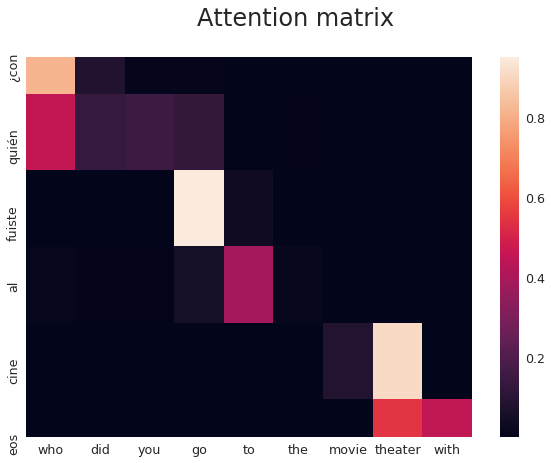

In [0]:
index = candidates[0][0].split()
columns = sentence.split()
df_cm = pd.DataFrame(attention_matrix[:len(index), -len(columns):],
                     index=index,
                     columns=columns)
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Attention matrix', fontsize=24)
sn.heatmap(df_cm)

### *Attention is all you need*

En 2017, Google publicó un artículo muy influyente con el título provocador "[Attention is all you need](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)" o, sólo hace falta atención. Consiguieron muy buenos resultados, batiendo algunos records, sólo con atención y sin ninguna RNN (LSTM, GRU, etc) ni convolución. Una de las innovaciones clave fue un encoder de la posición de cada palabra ("[positional encoding](https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/)"), lo que permite tratar frases enteras de manera global en lugar de palabra por palabra. El bloque de capas que constituye el encoder y el decoder se llama un [transformer](https://github.com/tensorflow/models/blob/master/official/transformer/model/transformer.py).
![](https://lilianweng.github.io/lil-log/assets/images/transformer.png)

### Attention is all you need

In 2017, Google published a very influential article with the provocative title "[Attention is all you need](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)" or , it only needs attention. They achieved very good results, beating some records, only with attention and without any RNN (LSTM, GRU, etc.) or convolution. One of the key innovations was an encoder of the position of each word ("[positional encoding](https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/)"), what which allows you to treat whole sentences globally instead of word for word. The layer block that constitutes the encoder and decoder is called a [transformer](https://github.com/tensorflow/models/blob/master/official/transformer/model/transformer.py).
![](https://lilianweng.github.io/lil-log/assets/images/transformer.png)

https://www.tensorflow.org/beta/tutorials/text/transformer

### TODO
*  Explain dot product attention better with an example
*  Use StackedRNNCells to make AttentionLSTM layer
*  Explain BERT, Positional Encoding, Multi-Head Attention, Feed Forward, Self-Attention, masking, training, fine-tune discrepancy 
*  Explain XLNet, AE and AR models